In [1]:
# Auto reload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
dataset_dir = '/Data/Dataset/Waymo/V1_2_tf/validation_interactive_extracted'
ckpt_path = '../weights/VBD_log_50_1_0.15_v2/epoch=19.ckpt'
anchor_path = '../vbd/data/cluster_64_center_dict.pkl'

# Generating Traffic Scenarios without Guidance
This notebook is a simple example of how to generate traffic scenarios without guidance. 

In [ ]:
## Import Dependencies
import torch
import numpy as np
from vbd.model.utils import set_seed
set_seed(0)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')
import jax
jax.config.update('jax_platform_name', 'cpu')

from waymax import dynamics
from waymax.config import EnvironmentConfig, ObjectType
from vbd.waymax_visualization.plotting import plot_state
import mediapy
import matplotlib.pyplot as plt


## Set Environment
env_config = EnvironmentConfig(
    # Ensure that the sim agent can control all valid objects.
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=11,
    max_num_objects=128,
)

from vbd.sim_agent.waymax_env import WaymaxEnvironment
from vbd.data.waymax_utils import smooth_scenario
dynamics_model = dynamics.StateDynamics()
env = WaymaxEnvironment(
    dynamics_model=dynamics_model,
    config=env_config,
    log_replay = True,
)

# Create Dataset
from vbd.data.dataset import WaymaxTestDataset

dataset = WaymaxTestDataset(
    data_dir = dataset_dir,
    anchor_path = anchor_path,
)

# Load model
from vbd.sim_agent.sim_actor import VBDTest, sample_to_action
model = VBDTest.load_from_checkpoint(ckpt_path,map_location=torch.device('cpu'))
_ = model.cuda()
_ = model.eval()
print("Load from: ", ckpt_path)
A = 32
model.reset_agent_length(A)
dataset.max_object  = A

Found 43481 scenarios


/home/zixuzhang/mambaforge/envs/waymax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zixuzhang/mambaforge/envs/waymax/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.1.0


Load from:  ../weights/VBD_log_50_1_0.15_v2/epoch=19.ckpt


## Load one scenario and visualize the log replay

""

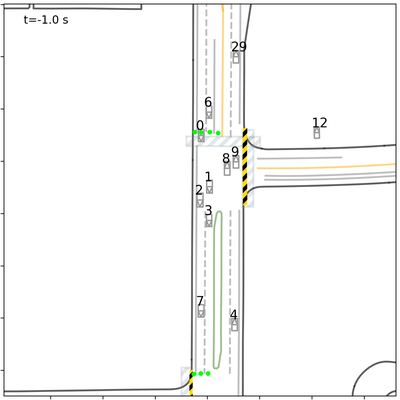

697a2d51e6e1b88b


In [8]:
i = np.random.randint(len(dataset))
scenario_id, scenario, _ = dataset.get_scenario_by_index(i)
mediapy.show_image(plot_state(scenario, log_traj=True))
print(scenario_id)

## Closed Loop Roll Out

In [10]:
model.cuda()
replan_freq=10 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None
remove_history = False

In [12]:
init_state = env.reset(scenario)
current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=True,
  remove_history=remove_history
)

is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

# Update object meta data
print(selected_agents)

state_logs = [current_state]

# x_t = torch.randn(1, A, 40, 2, device=model.device)
x_t = torch.zeros(1, A, 40, 2, device=model.device)


for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", current_state.timestep)
        sample = dataset.process_scenario(
          current_state, 
          current_index = current_state.timestep,
          use_log=i==0,
          selected_agents=selected_agents, # override the agent selection by distance to the ego
          remove_history=remove_history
        )
        batch = dataset.__collate_fn__([sample])
        pred = model.sample_denoiser(batch, x_t=x_t)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    action_sample = traj_pred[:, t, :]
    
    action = sample_to_action(action_sample, is_controlled, agents_id= selected_agents)

    current_state = env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)
    

/home/zixuzhang/Documents/Git/diffusion_waymax/vbd/data/data_utils.py:294: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  agents_history[i][~log_trajectory.valid[a, :current_index+1]] = 0


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Replan at  10


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.02it/s]


Replan at  20


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.44it/s]


Replan at  30


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.34it/s]


Replan at  40


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.33it/s]


Replan at  50


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.32it/s]
/home/zixuzhang/Documents/Git/diffusion_waymax/vbd/data/data_utils.py:304: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  agents_future[i][~log_trajectory.valid[a, current_index:]] = 0


Replan at  60


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.58it/s]


Replan at  70


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.51it/s]


Replan at  80


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.60it/s]


## Generate Video

In [13]:
imgs = [plot_state(state, log_traj=False) for state in state_logs]
mediapy.show_video(imgs, fps=10)